In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import torch

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
def train_model(model, optimizer, train_indices, test_indices, X_train, Y_train, X_test, Y_test, epochs=500):
    X_train = X_train
    Y_train = Y_train

    train_accuracy = []
    test_accuracy = []
    for i in range(epochs):
        model.zero_grad()
        output = model(X_train.view(len(train_indices), 1, 64, 64))
        loss = F.cross_entropy(output, Y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        tr_accuracy = test_model(model, train_indices, X_train, Y_train)
        train_accuracy.append(tr_accuracy)
        output_test = model(X_test.view(len(test_indices), 1, 64, 64))
        loss_test = F.cross_entropy(output_test, Y_test)
        tst_accuracy = test_model(model, test_indices, X_test, Y_test)
        test_accuracy.append(tst_accuracy)
    
    return model, train_accuracy, test_accuracy

In [3]:
def test_model(model, indices, X_samp, Y_samp):
    output_test = model(X_samp.view(len(indices), 1, 64, 64))
    total = 0
    correct = 0
    for i, out_t in enumerate(output_test):
        if int(torch.argmax(out_t)) - int(Y_samp[i]) == 0:
            correct = correct + 1
        total = total + 1

    return (correct/total)

In [4]:
X = np.load("datasets/sign-language/X.npy")
Y = np.load("datasets/sign-language/Y.npy")

In [5]:
def partition_data(X, Y):
    num_samples, _, _ = X.shape
    samples_by_digit = {
        0: [],
        1: [],
        2: [],
        3: [],
        4: [],
        5: [],
        6: [],
        7: [],
        8: [],
        9: []
    }
    for i in range(num_samples):
        samples_by_digit[np.argmax(Y[i])].append(i)
    
    train_indices = []
    test_indices = []
    for _, digit_sample_indices in samples_by_digit.items():
        random.shuffle(digit_sample_indices)
        train_indices = train_indices + digit_sample_indices[:int(0.8 * len(digit_sample_indices))]
        test_indices = test_indices + digit_sample_indices[int(0.8 * len(digit_sample_indices)):]
    
    random.shuffle(train_indices)
    random.shuffle(test_indices)
    X_train = [X[i] for i in train_indices]
    Y_train = [int(torch.argmax(torch.tensor(Y[i]))) for i in train_indices]
    X_test = [X[i] for i in test_indices]
    Y_test = [int(torch.argmax(torch.tensor(Y[i]))) for i in test_indices]
    
    return X_train, X_test, Y_train, Y_test, test_indices, train_indices

In [6]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # self.fc1 = nn.Linear(64*64, 192)
        self.conv1 = nn.Conv2d(1, 18, kernel_size=3, stride=1, padding=1)
        self.fc2 = nn.Linear(18*64*64, 192)
        self.fc3 = nn.Linear(192, 192)
        self.fc4 = nn.Linear(192, 192)
        self.fc5 = nn.Linear(192, 192)
        self.fc6 = nn.Linear(192, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 18*64*64)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        
        return F.softmax(x, dim=1)

In [7]:
X = np.load("datasets/sign-language/X.npy")
Y = np.load("datasets/sign-language/Y.npy")

In [8]:
import random
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_train, X_test, Y_train, Y_test, test_indices, train_indices = partition_data(X, Y)

In [9]:
X_train = torch.tensor(X_train).float().to(device)
Y_train = torch.tensor(Y_train).to(device)
X_test = torch.tensor(X_test).float().to(device)
Y_test = torch.tensor(Y_test).to(device)

In [10]:
net = Net().cuda()

In [11]:
output = net(X_train[0].view(1, 1, 64, 64))
output

tensor([[0.0961, 0.0952, 0.1009, 0.1076, 0.0968, 0.1066, 0.0999, 0.1017, 0.0975,
         0.0977]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [12]:
optimizer = optim.Adam([net.conv1.weight, net.fc2.weight, net.fc3.weight, net.fc4.weight, net.fc5.weight, net.fc6.weight], lr=0.001)
net, train_accuracy, test_accuracy = train_model(net, optimizer, train_indices, test_indices, X_train, Y_train, X_test, Y_test)

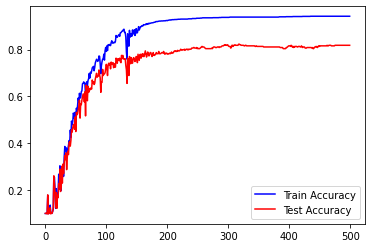

In [13]:
fig, ax = plt.subplots()
ax.plot(train_accuracy, "b-", label="Train Accuracy")
ax.plot(test_accuracy, "r-", label="Test Accuracy")
leg = ax.legend()

In [14]:
test_result = test_model(net, test_indices, X_test, Y_test)
print(test_result)

0.8181818181818182


In [15]:
class NetTwo(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.max_pool = nn.MaxPool2d(2, stride=2)
        self.dense = nn.Linear(32*32, 128)
        self.dense_output = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = x.view(-1, 1*32*32)
        x = F.relu(self.dense(x))
        x = self.dense_output(x)
        
        return F.softmax(x, dim=1)

In [16]:
net_two = NetTwo().cuda()

In [17]:
output_two = net_two(X_train[0].view(1, 1, 64, 64))
output_two

tensor([[0.1006, 0.0852, 0.1090, 0.0925, 0.0935, 0.1007, 0.1003, 0.1124, 0.0986,
         0.1072]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [18]:
optimizer = optim.Adam([net_two.conv1.weight, net_two.dense.weight, net_two.dense_output.weight], lr=0.001)
net_two, train_accuracy, test_accuracy = train_model(net_two, optimizer, train_indices, test_indices, X_train, Y_train, X_test, Y_test)



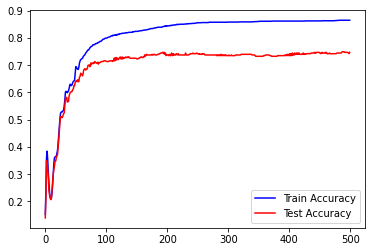

In [19]:
fig, ax = plt.subplots()
ax.plot(train_accuracy, "b-", label="Train Accuracy")
ax.plot(test_accuracy, "r-", label="Test Accuracy")
leg = ax.legend()

In [115]:
test_result = test_model(net_two, test_indices, X_test, Y_test)
print(test_result)

0.7464114832535885


In [125]:
class NetThree(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.max_pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.max_pool2 = nn.MaxPool2d(2, stride=2)
        self.dense = nn.Linear(16*16, 128)
        self.dense_output = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        x = x.view(-1, 1*16*16)
        x = F.relu(self.dense(x))
        x = self.dense_output(x)
        
        return F.softmax(x, dim=1)

In [126]:
net_three = NetThree().cuda()

In [127]:
output_three = net_three(X_train[0].view(1, 1, 64, 64))
output_three

tensor([[0.1003, 0.1015, 0.0980, 0.1028, 0.1075, 0.0919, 0.0938, 0.1038, 0.1040,
         0.0965]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [128]:
optimizer = optim.Adam(net_three.parameters(), lr=0.001)
net_three, train_accuracy, test_accuracy = train_model(net_three, optimizer, train_indices, test_indices, X_train, Y_train, X_test, Y_test, epochs=1000)

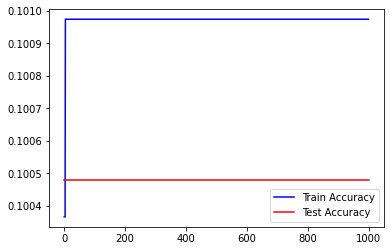

In [129]:
fig, ax = plt.subplots()
ax.plot(train_accuracy, "b-", label="Train Accuracy")
ax.plot(test_accuracy, "r-", label="Test Accuracy")
leg = ax.legend()

In [130]:
test_result = test_model(net_three, test_indices, X_test, Y_test)
print(test_result)

0.10047846889952153


In [132]:
output_test = net_three(X_test.view(-1, 1, 64, 64))

In [140]:
net_three.conv1.weight

Parameter containing:
tensor([[[[-0.0941,  0.2357,  0.1852],
          [-0.2312,  0.1925,  0.1058],
          [-0.1028,  0.0574, -0.2448]]]], device='cuda:0', requires_grad=True)

In [119]:
class NetFour(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.max_pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.max_pool2 = nn.MaxPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.max_pool3 = nn.MaxPool2d(2, stride=2)
        self.dense = nn.Linear(8*8, 128)
        self.dense_output = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        x = F.relu(self.conv3(x))
        x = self.max_pool3(x)
        x = x.view(-1, 1*8*8)
        x = F.relu(self.dense(x))
        x = self.dense_output(x)
        
        return F.softmax(x, dim=1)

In [120]:
net_four = NetFour().cuda()

In [121]:
output_four = net_four(X_train[0].view(1, 1, 64, 64))
output_four

tensor([[0.1032, 0.0857, 0.1044, 0.0914, 0.0894, 0.1031, 0.1116, 0.1052, 0.1056,
         0.1003]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [122]:
optimizer = optim.Adam(net_four.parameters(), lr=0.001)
net_four, train_accuracy, test_accuracy = train_model(net_four, optimizer, train_indices, test_indices, X_train, Y_train, X_test, Y_test, epochs=3000)

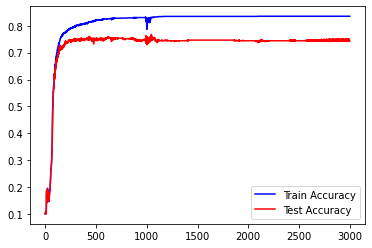

In [123]:
fig, ax = plt.subplots()
ax.plot(train_accuracy, "b-", label="Train Accuracy")
ax.plot(test_accuracy, "r-", label="Test Accuracy")
leg = ax.legend()

In [124]:
test_result = test_model(net_four, test_indices, X_test, Y_test)
print(test_result)

0.7440191387559809


In [103]:
class NetFive(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.max_pool1 = nn.MaxPool2d(2, stride=2)
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.max_pool2 = nn.MaxPool2d(2, stride=2)
        self.dropout2 = nn.Dropout2d(p=0.25)
        self.conv3 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.max_pool3 = nn.MaxPool2d(2, stride=2)
        self.dropout3 = nn.Dropout2d(p=0.25)
        self.dense = nn.Linear(8*8, 128)
        self.dense_output = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        # x = self.dropout2(x)
        x = F.relu(self.conv3(x))
        x = self.max_pool3(x)
        # x = self.dropout3(x)
        x = x.view(-1, 1*8*8)
        x = F.relu(self.dense(x))
        x = self.dense_output(x)
        
        return F.softmax(x, dim=1)

In [104]:
net_five = NetFive().cuda()

In [105]:
output_five = net_five(X_train[0].view(1, 1, 64, 64))
output_five

tensor([[0.0960, 0.0918, 0.1082, 0.0905, 0.1016, 0.1051, 0.1076, 0.0971, 0.1006,
         0.1016]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [106]:
optimizer = optim.RMSprop(net_five.parameters(), lr=0.001)
net_five, train_accuracy, test_accuracy = train_model(net_five, optimizer, train_indices, test_indices, X_train, Y_train, X_test, Y_test, epochs=1000)

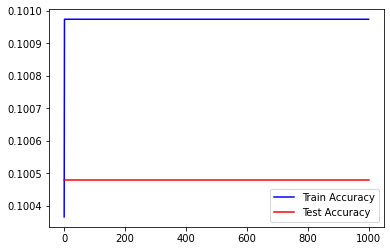

In [107]:
fig, ax = plt.subplots()
ax.plot(train_accuracy, "b-", label="Train Accuracy")
ax.plot(test_accuracy, "r-", label="Test Accuracy")
leg = ax.legend()

In [108]:
test_result = test_model(net_five, test_indices, X_test, Y_test)
print(test_result)

0.10047846889952153
